In [44]:
import numpy as np
import struct
import matplotlib.pyplot as plt
import pandas as pd

In [45]:
# ========== Load Dataset ==========
def load_images(filename):
    with open(filename, 'rb') as f:
        _, num, rows, cols = struct.unpack(">IIII", f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape((num,
        rows * cols))
    return data.astype(np.float32) / 255.0

def load_labels(filename):
    with open(filename, 'rb') as f:
        _, num = struct.unpack(">II", f.read(8))
        return np.frombuffer(f.read(), dtype=np.uint8)

In [46]:
# ========== 1. Sigmoid Function ==========
def sigmoid(z):
    # TODO: Implement sigmoid function (optional)
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

In [47]:
#TODO: Implement Backprop Autodiff
# ====== 3. Forward and Reverse Autodiff Trace ========
def trace_autodiff_example(x1, x2):
    # Primal 
    v1 = x1
    v2 = x2
    v3 = v1 * v2
    v4 = v3 * v2
    v5 = v4 + v3
    v6 = v5 * v1
    v7 = v6 + v5

    primal = [v1, v2, v3, v4, v5, v6, v7]

    # Forward tangent
    ft_v1 = 1        # derivative of v1 w.r.t v1
    ft_v2 = 0        # derivative of v2 w.r.t v1
    ft_v3 = ft_v1 * v2 + v1 * ft_v2
    ft_v4 = ft_v3 * v2 + v3 * ft_v2
    ft_v5 = ft_v4 + ft_v3
    ft_v6 = ft_v5 * v1 + v5 * ft_v1
    ft_v7 = ft_v6 + ft_v5
    
    forward_tangent = [ft_v1, ft_v2, ft_v3, ft_v4, ft_v5, ft_v6, ft_v7]

    # Reverse adjoint
    ra = [0] * 7
    ra[6] = 1                          # dv7/dv7
    ra[5] = ra[6] * 1                  # dv7/dv6 = 1
    ra[4] = ra[6] * 1 + ra[5] * v1     # dv7/dv5 + dv6/dv5
    ra[3] = ra[4] * 1                  # dv5/dv4
    ra[2] = ra[4] * 1 + ra[3] * v2     # dv5/dv3 + dv4/dv3
    ra[1] = ra[3] * v3 + ra[2] * v1    # dv4/dv2*v3 + dv3/dv2*v1
    ra[0] = ra[2] * v2 + ra[5] * v5    # dv3/dv1*v2 + dv6/dv1*v5

    reverse_adjoint = ra

    table = pd.DataFrame({
        'Variable': ['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7'],
        'Primal (v)': primal,
        'Forward Tangent (ẋ)': forward_tangent,
        'Reverse Adjoint (v̄)': reverse_adjoint
    })

    return table

In [48]:
#TODO: Implement SGD (use your codes last week), then use the backprop inside
# ========== 2. SGD: Algorithm 7.1 ==========
def your_sgd_logistic(X, y, eta, max_iters):
    w = np.zeros(X.shape[1])
    trace = None  # initialization of trace
    for iter in range(max_iters):
        for i in range(X.shape[0]):
            xi, yi = X[i], y[i]
            pred = sigmoid(np.dot(w, xi))
            gradient = (pred - yi) * xi
            
            if iter == 0 and i == 0:
                trace = trace_autodiff_example(xi[1]+1e-2, w[1]+1e-2)
                
            w -= eta * gradient
            
    return w, trace


In [49]:
# ==========Show Misclassified Samples ==========
def show_misclassified(X, y_true, y_pred, max_show=10):
    mis_idx = np.where(y_true != y_pred)[0][:max_show]
    if len(mis_idx) == 0:
        print("No misclassifications!")
        return
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(mis_idx):
        plt.subplot(1, len(mis_idx), i + 1)
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"T:{y_true[idx]}\nP:{y_pred[idx]}")
    plt.suptitle("Misclassified Samples")
    plt.show()

In [50]:
# ========== Plot Trace Graph ==========
def plot_autodiff_traces(trace_df):
    variables = trace_df['Variable']
    primal = trace_df['Primal (v)'].astype(float)
    forward = pd.to_numeric(trace_df['Forward Tangent (ẋ)'], errors='coerce')
    reverse = pd.to_numeric(trace_df['Reverse Adjoint (v̄)'], errors='coerce')
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    ax[0].bar(variables, primal, color='skyblue')
    ax[0].set_ylabel("Primal (v)")
    ax[0].set_title("Primal Values")
    ax[1].bar(variables, forward, color='lightgreen')
    ax[1].set_ylabel("Forward Tangent (ẋ)")
    ax[1].set_title("Forward-Mode Autodiff")
    ax[2].bar(variables, reverse, color='salmon')
    ax[2].set_ylabel("Reverse Adjoint (v̄)")
    ax[2].set_title("Reverse-Mode Autodiff")
    ax[2].set_xlabel("Variables")
    plt.tight_layout()
    plt.show()


Test Accuracy (is 3 or not): 0.9777


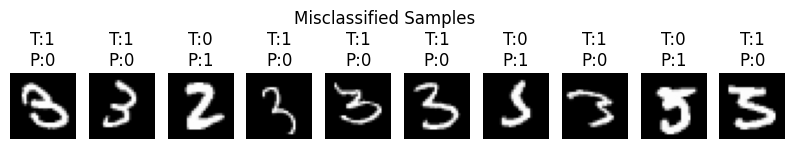


Autodiff Trace Table (sample features):
  Variable  Primal (v)  Forward Tangent (ẋ)  Reverse Adjoint (v̄)
0       v1    0.010000             1.000000              0.010302
1       v2    0.010000             0.000000              0.010302
2       v3    0.000100             0.010000              1.020100
3       v4    0.000001             0.000100              1.010000
4       v5    0.000101             0.010100              1.010000
5       v6    0.000001             0.000202              1.000000
6       v7    0.000102             0.010302              1.000000


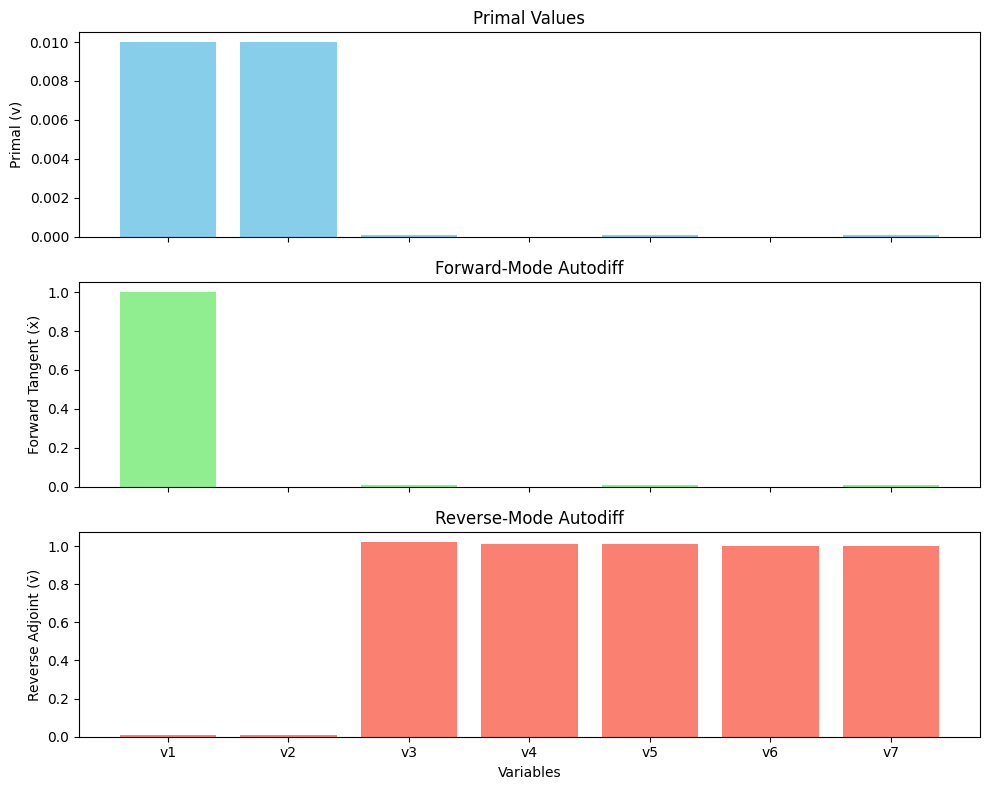

In [51]:
# ========== 3. Main ==========
def main():
    # === Load MNIST Data ===
    X_train = load_images("data/train-images.idx3-ubyte____")
    y_train = load_labels("data/train-labels.idx1-ubyte____")
    X_test = load_images("data/t10k-images.idx3-ubyte____")
    y_test = load_labels("data/t10k-labels.idx1-ubyte____")
    # === Binary Classification ===
    TARGET_DIGIT = 3 # TODO: Fill in (0 to 9) based on your student number
    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0)
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)
    # === Add Bias ===
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
    # === Train ===
    # === Set parameters ===
    eta = 0.01 # Learning rate
    max_iters = 10 # Number of SGD iterations
    w, autodiff_trace = your_sgd_logistic(X_train, y_train_bin, eta, max_iters)

    # === Predict ===
    pred_probs = sigmoid(X_test.dot(w))
    preds = (pred_probs >= 0.5).astype(int)
    
    # === Accuracy ===
    acc = np.mean(preds == y_test_bin)
    print(f"\nTest Accuracy (is {TARGET_DIGIT} or not): {acc:.4f}")

    # # === Show Misclassifications ===
    show_misclassified(X_test, y_test_bin, preds)
    
    # === Visualize Autodiff Trace ===
    print("\nAutodiff Trace Table (sample features):")
    print(autodiff_trace)
    plot_autodiff_traces(autodiff_trace)

main()